In [32]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import G, M_sun
from scipy.interpolate import interp1d
from matplotlib import colors 
from scipy.integrate import simps
from scipy import interpolate
import astropy.units as u
import tqdm
import numpy as np
import warnings
import sys
sys.path.append('../my_funcs/')
from pipeline_main import pipeline
#from pipeline_stress import _fill_2Dhist
from pipeline_1D import *
from pipeline_stress import _fill_2Dhist


# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

# How to connect the knowledge of the three stresses, angular momentum transport and the α-parameter
### Form Suziki et al. (2016) Appendix A Eq. A.3 and A.4:
### $$\rho\alpha_{r\phi}c_s^2 = \rho v_r\delta v_\phi - \frac{B_rB_\phi}{4\pi} + \frac{(\nabla\Phi)_\phi(\nabla\Phi)_r}{4\pi G}$$
### $$\rho\alpha_{\phi z}c_s^2 = \rho v_z\delta v_\phi - \frac{B_zB_\phi}{4\pi} + \frac{(\nabla\Phi)_\phi(\nabla\Phi)_z}{4\pi G}$$
### $$v_\phi=r\Omega + \delta v_\phi,\quad\quad *C_s^2 = \frac{P}{\rho}$$
# $$\Leftrightarrow$$
### $$\alpha_{r\phi} (c_s^2)_{mid}= \left[v_r\delta v_\phi - \frac{B_rB_\phi}{4\pi\rho} + \frac{(\nabla\Phi)_\phi(\nabla\Phi)_r}{4\pi G\rho}\right]$$
### $$\alpha_{\phi z} (c_s^2)_{mid}= \left[v_z\delta v_\phi - \frac{B_zB_\phi}{4\pi\rho} + \frac{(\nabla\Phi)_\phi(\nabla\Phi)_z}{4\pi G\rho}\right]$$
### *$C_s$ could also be defined from the temperature as in Suzuki
### I only use the midplane sound speed since ρ has to be integrated over $z$ to become $Σ$

# This notebook is made by exracting values over only and z so the final plots is 1-dimensional
### The height used for integration is gathered from the Σ and scaleheight 1D fit

Initialising patch data
Assigning relative cartesian velocities and coordinates to all cells
Assigning masses to all cells
Calculating adiabatic index γ and pressure (polytropic) for all cells


100%|██████████| 5026/5026 [00:16<00:00, 299.82it/s]


Converged mean angular momentum vector after 0 iteration(s)
Looping through patches, assigning azimuthal velocities to all cells and extracing them within given cylindrical coordiantes


100%|██████████| 5026/5026 [00:00<00:00, 17344.14it/s]


Disk size: 220.6 au
Transforming old z-coordinate into mean angular momentum vector


100%|██████████| 5026/5026 [00:02<00:00, 2296.50it/s]


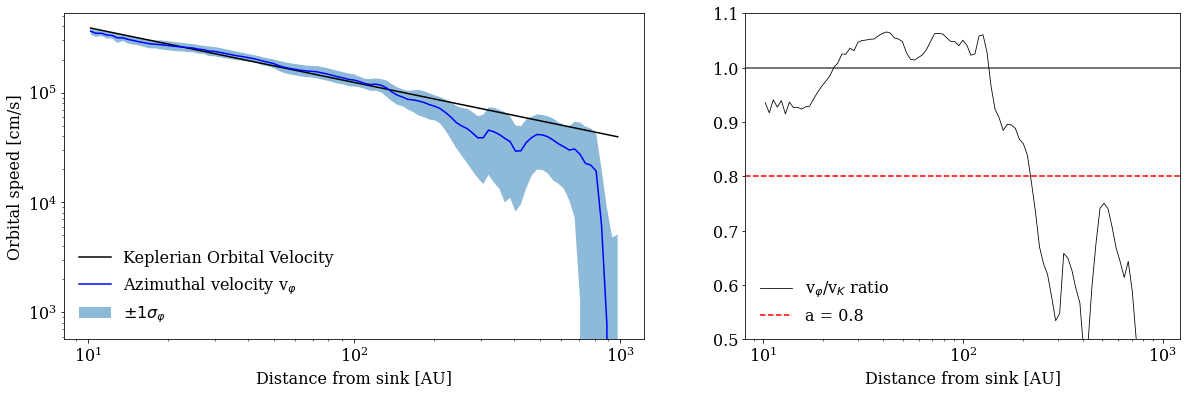

In [33]:
#data = pipeline(snap = 535, run = 'sink178core03', sink_id=178)
data = pipeline(snap = 463, run = 'sink122core02', sink_id=122)
data.recalc_L(verbose = 1); 
data.calc_disksize(plot = True); data.calc_trans_xyz()

Looping through patches to extract densities and heights
Fitting surface density and scaleheight in each radial bin


100%|██████████| 199/199 [00:06<00:00, 30.22it/s]


Validating fit...
Extracting azimuthal, angular velocities and adiabatic index data from patches into 1D


100%|██████████| 2356/2356 [00:07<00:00, 329.65it/s]
/lustre/hpc/astro/kxm508/codes/dispatch2/experiments/ISM/python/stresses/../my_funcs/pipeline_1D.py:187: RuntimeWarning: invalid value encountered in sqrt
  σ_γ = np.sqrt(γ2 - γ**2)


Calculating isothermal sound speed c_s = (γP/ρ)^0.5


100%|██████████| 2356/2356 [00:06<00:00, 363.87it/s]


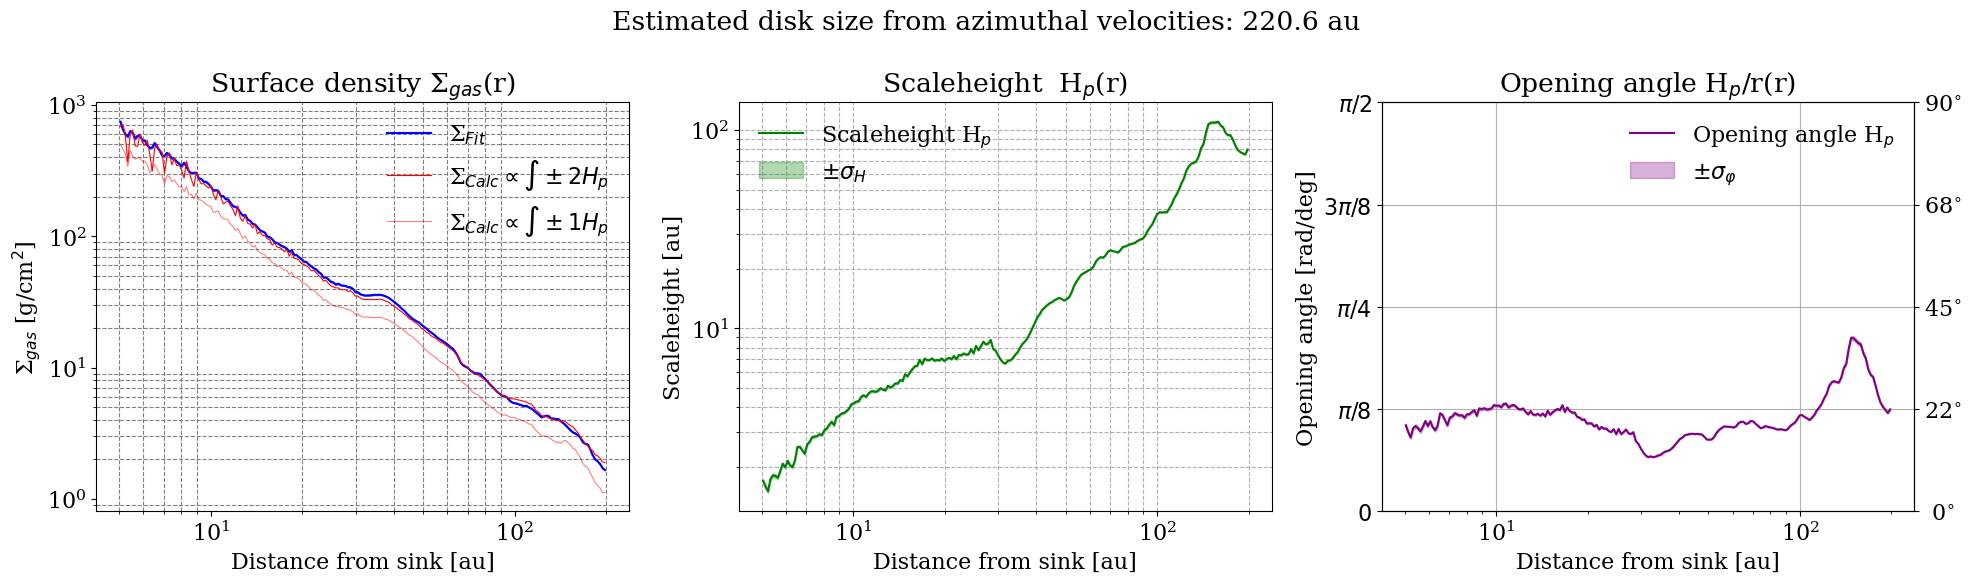

In [34]:
data.to_1D(plot = True, r_in= 5, r_out = 200, Nr = 200)
data.get_1D_param(cs=True, get_units = False)

In [35]:
cs_func = interp1d(data.r_1D * data.au_length, data.cs_1D[:,0], fill_value='extrapolate')
Hp_func = interp1d(data.r_1D * data.au_length, data.H_1D[:,0], fill_value='extrapolate')
Σ_func = interp1d(data.r_1D * data.au_length, data.Σ_1D[:,0], fill_value='extrapolate')

In [36]:
radius = 10; Nh = 1000; shell_Δpct = 0.05; N_Hp = 3
G_cgs = G.to('cm**3 / (g * s**2)').value
height = N_Hp * Hp_func(radius) / data.au_length
radius /= data.au_length; 
shell_Δ = np.maximum(shell_Δpct * radius, 0.5**(data.lmax))
selection_radius = np.sqrt(radius**2 + height**2) * 2

pp = [p for p in data.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
w= np.array([p.level for p in pp]).argsort()[::-1]
sorted_patches = [pp[w[i]] for i in range(len(pp))]

extracted_values =  {key: [] for key in range(6)}

for p in sorted_patches:
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [ n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
    if len(leafs) == 8: continue

    p.B = np.concatenate([p.var(f'b'+axis)[None,...] for axis in ['x','y','z']], axis = 0)
    p.gradφ = np.array(np.gradient(p.var('phi'), p.ds[0], edge_order = 2))
    p.Bφ = np.sum(p.B * p.e_φ, axis = 0)
    p.Br = np.sum(p.B * p.e_r, axis = 0)
    p.vφ = np.sum(p.vrel * p.e_φ, axis = 0)
    p.vr = np.sum(p.vrel * p.e_r, axis = 0)
    p.gradφ_φ = np.sum(p.gradφ * p.e_φ, axis = 0)
    p.gradφ_r = np.sum(p.gradφ * p.e_r, axis = 0)

    to_extract = (p.cyl_R > radius - shell_Δ) & (p.cyl_R <  radius + shell_Δ)
    for lp in leafs: 
        leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
        covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
        to_extract *= covered_bool 

    r_coor = p.cyl_R[to_extract].T 
    z_coor = p.cyl_z[to_extract].T 
    v_r = p.vr[to_extract].T
    v_φ = p.vφ[to_extract].T
    B_φr =  p.Br[to_extract].T * p.Bφ[to_extract].T / p.var('d')[to_extract].T
    mass_val = p.m[to_extract].T 
    gradφ_φr = p.gradφ_r[to_extract].T * p.gradφ_φ[to_extract].T / p.var('d')[to_extract].T

    kep_V = np.sqrt((G_cgs * data.M_star.to('g').value) / (r_coor * data.sn.scaling.l))
    δv_φ = v_φ  - kep_V / data.cms_velocity

    extracted_values[0].extend(z_coor.tolist())
    extracted_values[1].extend((δv_φ * v_r).tolist())    
    extracted_values[2].extend(mass_val.tolist())
    extracted_values[3].extend(B_φr.tolist())
    extracted_values[4].extend(gradφ_φr.tolist())
    extracted_values[5].extend(p.ds[0]**3 * np.ones(len(mass_val)))

for key in extracted_values:
    extracted_values[key] = np.array(extracted_values[key])

z_grid = np.linspace(-height, height, Nh)
hist_mass, binedges_z = np.histogram(extracted_values[0], bins = z_grid , weights = extracted_values[2])
hist_vol, _ = np.histogram(extracted_values[0], bins = z_grid , weights = extracted_values[5])

hist_ρ = hist_mass / hist_vol * data.cgs_density
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    hist_δvφvr = np.histogram(extracted_values[0],  bins = z_grid, weights = extracted_values[1] * extracted_values[2])[0] / hist_mass 
    hist_BφBr = np.histogram(extracted_values[0],  bins = z_grid, weights = extracted_values[3] * extracted_values[2])[0] / hist_mass 
    hist_gradφ_φr =np.histogram(extracted_values[0],  bins = z_grid, weights = extracted_values[4] * extracted_values[2])[0] / hist_mass 

reynolds_radial = hist_δvφvr * data.cms_velocity**2
maxwell_radial = hist_BφBr / (4 * np.pi) * data.sn.scaling.b**2 / data.cgs_density
grav_radial = hist_gradφ_φr / (4 * np.pi * G_cgs) * (data.cms_velocity / data.sn.scaling.t)**2 / data.cgs_density
total =  reynolds_radial - maxwell_radial + grav_radial
z_bins = z_grid[:-1] + 0.5 * np.diff(binedges_z)

/tmp/ipykernel_2130431/2375291207.py:60: RuntimeWarning: invalid value encountered in true_divide
  hist_ρ = hist_mass / hist_vol * data.cgs_density


# How to normalize $\alpha_{r\phi}$:
### $$\overline{\alpha_{r\phi}} = \frac{\int\rho\alpha_{r\phi}dz}{\Sigma}$$
### $$\alpha_{r\phi}= \frac{1}{(c_s^2)_{mid}}\left[v_r\delta v_\phi - \frac{B_rB_\phi}{4\pi\rho} + \frac{(\nabla\Phi)_\phi(\nabla\Phi)_r}{4\pi G\rho}\right]$$

## See $Σ = \int\rho dz$ check below ($3\cdot H_p$)

In [37]:
simps(hist_ρ, z_bins * data.sn.scaling.l), Σ_func(radius * data.au_length)

(nan, array(239.16025345))

In [38]:
α_rφ = total / cs_func(radius * data.au_length)**2
avg_αrφ = simps(α_rφ * hist_ρ, z_bins * data.sn.scaling.l) /  Σ_func(radius * data.au_length)
avg_αrφ

nan

In [39]:
α_rφ.min()

nan

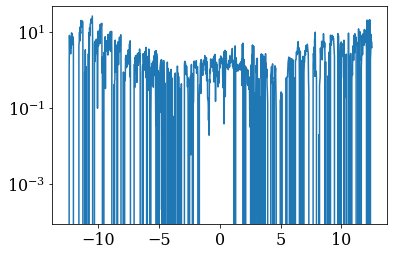

In [40]:
plt.semilogy(z_bins * data.au_length, α_rφ)

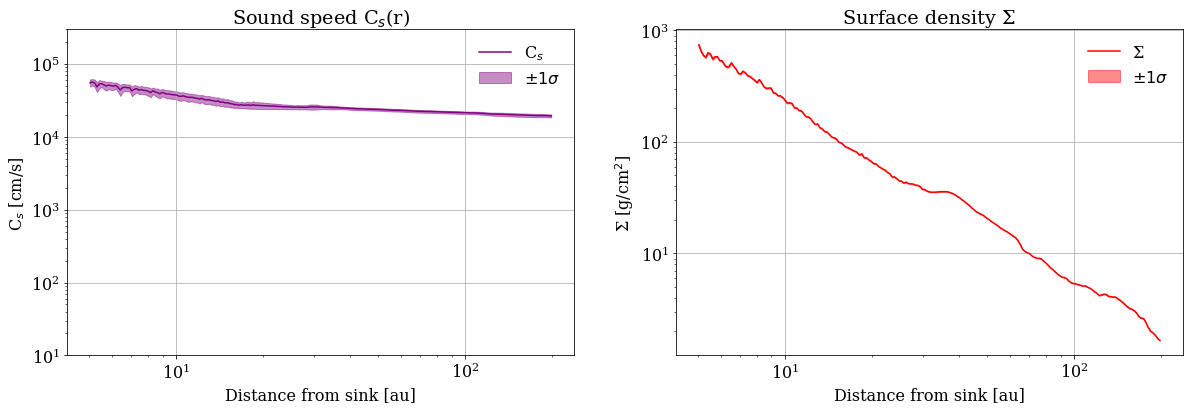

In [41]:
fig, ax = plt.subplots(1, 2, figsize = (20,6))
axs = ax[0]
axs.grid('--')
axs.loglog(data.r_1D * data.au_length, data.cs_1D[:,0] , color = 'purple', label = 'C$_s$')
axs.fill_between(data.r_1D * data.au_length, data.cs_1D[:,0] + data.cs_1D[:,1], data.cs_1D[:,0] - data.cs_1D[:,1], color = 'purple', alpha = 0.45, label = '$\pm 1σ$')
axs.set(title = 'Sound speed C$_s$(r)', ylabel = 'C$_s$ [cm/s]', xlabel = 'Distance from sink [au]', ylim = (1e1, 3e5))
axs.legend(frameon = False)

axs = ax[1]
axs.grid('--')
axs.loglog(data.r_1D * data.au_length, data.Σ_1D[:,0] , color = 'red', label = 'Σ')
axs.fill_between(data.r_1D * data.au_length, data.Σ_1D[:,0] + data.Σ_1D[:,1], data.Σ_1D[:,0] - data.Σ_1D[:,1], color = 'red', alpha = 0.45, label = '$\pm 1σ$')
axs.set(title = 'Surface density Σ', ylabel = 'Σ [g/cm$^2$]', xlabel = 'Distance from sink [au]')
axs.legend(frameon = False)

In [42]:
for p in data.sn.patches:
    if p.id == 1853: break

# Now making it into a function that deals with the complete disk

In [43]:
data.to_1D(plot = False, r_in= 5, r_out = 200, Nr = 200)
data.get_1D_param(Ω = True, T=True, get_units = False)
data.calc_cs1D(method='settled_disk')
radii = data.r_1D

Looping through patches to extract densities and heights
Fitting surface density and scaleheight in each radial bin


100%|██████████| 199/199 [00:06<00:00, 29.77it/s] 


Extracting azimuthal, angular velocities and adiabatic index data from patches into 1D


100%|██████████| 2356/2356 [00:06<00:00, 340.49it/s]

Calculating temperature from sound speed
Calculating sound speed assuming a thin settled disk c_s = ΩΗ



/lustre/hpc/astro/kxm508/codes/dispatch2/experiments/ISM/python/stresses/../my_funcs/pipeline_1D.py:187: RuntimeWarning: invalid value encountered in sqrt
  σ_γ = np.sqrt(γ2 - γ**2)


In [44]:
shell_Δpct = 0.01; N_Hp = 3
average_αrφ = np.zeros_like(radii)
Nh_cells = np.ceil([2 * N_Hp * data.H_1D[i,0] / (0.5**data.lmax * data.au_length) for i in range(len(radii))]).astype(int)
vertical_αrφ = {key: np.zeros(N) for N, key in zip(Nh_cells, range(len(Nh_cells)))}
components_αrφ = np.zeros((3, len(radii)))


radii_interpolated = []
selection_radius = np.sqrt(radii[-1]**2 + (data.H_1D[-1,0] / data.au_length)**2) * 2

pp = [p for p in data.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
w = np.array([p.level for p in pp]).argsort()[::-1]
sorted_patches = [pp[w[i]] for i in range(len(pp))]

for j in tqdm.tqdm(range(len(radii))):
    radius = radii[j]; Nh = Nh_cells[j]; shell_Δpct = 0.05;
    G_cgs = G.to('cm**3 / (g * s**2)').value
    height = N_Hp * data.H_1D[j,0] / data.au_length
    shell_Δ = np.maximum(shell_Δpct * radius, 0.5**(data.lmax))

    extracted_values =  {key: [] for key in range(6)}

    for p in sorted_patches:
        nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
        children = [ n for n in nbors if n.level == p.level + 1]
        leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
        if len(leafs) == 8: continue

        p.B = np.concatenate([p.var(f'b'+axis)[None,...] for axis in ['x','y','z']], axis = 0)
        p.gradφ = np.array(np.gradient(p.var('phi'), p.ds[0], edge_order = 2))
        p.Bφ = np.sum(p.B * p.e_φ, axis = 0)
        p.Br = np.sum(p.B * p.e_r, axis = 0)
        p.vφ = np.sum(p.vrel * p.e_φ, axis = 0)
        p.vr = np.sum(p.vrel * p.e_r, axis = 0)
        p.gradφ_φ = np.sum(p.gradφ * p.e_φ, axis = 0)
        p.gradφ_r = np.sum(p.gradφ * p.e_r, axis = 0)

        to_extract = (p.cyl_R > radius - shell_Δ) & (p.cyl_R <  radius + shell_Δ)
        for lp in leafs: 
            leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
            covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
            to_extract *= covered_bool 

        r_coor = p.cyl_R[to_extract].T 
        z_coor = p.cyl_z[to_extract].T 
        v_r = p.vr[to_extract].T
        v_φ = p.vφ[to_extract].T
        B_φr =  p.Br[to_extract].T * p.Bφ[to_extract].T / p.var('d')[to_extract].T
        mass_val = p.m[to_extract].T 
        gradφ_φr = p.gradφ_r[to_extract].T * p.gradφ_φ[to_extract].T / p.var('d')[to_extract].T

        kep_V = np.sqrt((G_cgs * data.M_star.to('g').value) / (r_coor * data.sn.scaling.l))
        δv_φ = v_φ  - kep_V / data.cms_velocity

        extracted_values[0].extend(z_coor.tolist())
        extracted_values[1].extend((δv_φ * v_r).tolist())    
        extracted_values[2].extend(mass_val.tolist())
        extracted_values[3].extend(B_φr.tolist())
        extracted_values[4].extend(gradφ_φr.tolist())
        extracted_values[5].extend(p.ds[0]**3 * np.ones(len(mass_val)))

    for key in extracted_values:
        extracted_values[key] = np.array(extracted_values[key])

    z_grid = np.linspace(-height, height, Nh)
    hist_mass, binedges_z = np.histogram(extracted_values[0], bins = z_grid , weights = extracted_values[2])
    hist_vol, _ = np.histogram(extracted_values[0], bins = z_grid , weights = extracted_values[5])

   
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        hist_ρ = hist_mass / hist_vol * data.cgs_density
        hist_δvφvr = np.histogram(extracted_values[0],  bins = z_grid, weights = extracted_values[1] * extracted_values[2])[0] / hist_mass 
        hist_BφBr = np.histogram(extracted_values[0],  bins = z_grid, weights = extracted_values[3] * extracted_values[2])[0] / hist_mass 
        hist_gradφ_φr =np.histogram(extracted_values[0],  bins = z_grid, weights = extracted_values[4] * extracted_values[2])[0] / hist_mass 

    reynolds_radial = hist_δvφvr * data.cms_velocity**2
    maxwell_radial = hist_BφBr / (4 * np.pi) * data.sn.scaling.b**2 / data.cgs_density
    grav_radial = hist_gradφ_φr / (4 * np.pi * G_cgs) * (data.cms_velocity / data.sn.scaling.t)**2 / data.cgs_density
    total =  reynolds_radial - maxwell_radial + grav_radial
    z_bins = z_grid[:-1] + 0.5 * np.diff(binedges_z)

    if np.sum(np.isnan(total)) != 0:
        ma = np.ma.masked_array(total, mask = np.isnan(total))
        total = interpolate.griddata(total[~ma.mask], ma[~ma.mask], xi = z_bins, method = 'nearest')
        hist_ρ = interpolate.griddata(hist_ρ[~ma.mask], ma[~ma.mask], xi = z_bins, method = 'nearest')
        radii_interpolated.append(j)    

    α_rφ = total / data.cs_1D[j,0]**2
    vertical_αrφ[j] = α_rφ
    average_αrφ[j] = simps(α_rφ * hist_ρ, z_bins * data.sn.scaling.l) /  data.Σ_1D[j,0]
    components_αrφ[0, j] = simps(reynolds_radial / data.cs_1D[j,0]**2 * hist_ρ, z_bins * data.sn.scaling.l) /  data.Σ_1D[j,0]
    components_αrφ[1, j] = simps(-maxwell_radial / data.cs_1D[j,0]**2 * hist_ρ, z_bins * data.sn.scaling.l) /  data.Σ_1D[j,0]
    components_αrφ[2, j] = simps(grav_radial / data.cs_1D[j,0]**2 * hist_ρ, z_bins * data.sn.scaling.l) /  data.Σ_1D[j,0]

print(f'Number of radii interpolated: {len(radii_interpolated)}')


  0%|          | 0/199 [00:00<?, ?it/s]

100%|██████████| 199/199 [13:02<00:00,  3.93s/it]

Number of radii interpolated: 0


In [45]:
stress_names = ['Reynolds', '- Maxwells', 'Grav. instability']
color = ['red', 'blue', 'green']

(1e-06, 100.0)

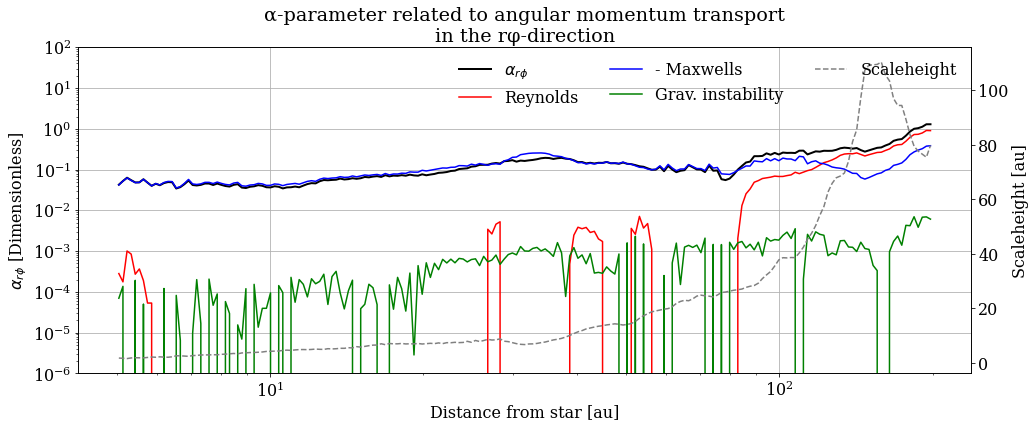

In [46]:
fig, axs = plt.subplots(figsize = (16,6))
axs.grid('--')

lab0 = axs.loglog(data.r_1D * data.au_length, average_αrφ, color = 'black', label = '$α_{r\phi}$', lw = 2)

for i in range(3):
    exec(f'lab{i+1} = axs.semilogx(data.r_1D * data.au_length, components_αrφ[i], label = stress_names[i], color = color[i])')

axs.set(ylabel = '$α_{r\phi}$ [Dimensionless]', xlabel  = 'Distance from star [au]', title = 'α-parameter related to angular momentum transport\nin the rφ-direction')
axs2 = axs.twinx()
lab4 = axs2.semilogx(data.r_1D * data.au_length, data.H_1D[:,0], color = 'grey', ls = '--', label = 'Scaleheight')
axs2.set(ylabel = 'Scaleheight [au]')

lns = lab0 + lab1 + lab2 + lab3 + lab4
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, frameon = False, ncol = 3, loc = 'upper right')
axs.set_ylim(1e-6, 1e2)